In [1]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.weightstats as smS

WMN = 'WMN'
WSL = 'WSL'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 2

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,110]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,110]']

PressFluc_bins = [0,3,6,9,12,15,20,35]
PFlucRange_labels = ['(0,3]','(3,6]','(6,9]','(9,12]','(12,15]','(15,20]','(20,35]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

In [2]:
def filterFailuresbyInconsistentAddress(failures, addressRecords, assetAddresses):

	#adds the compkeys to the addressess of the failure table 
    failAddr= failures.join(addressRecords)[[COMPKEY,'Street_Type','Street_Name',SUBURB]]
    failAddr=failAddr.astype({COMPKEY: 'int64'})

	#creates the table to compare addresses 
    addrComp= failAddr.join(assetAddresses, on=COMPKEY)

	#compare the suburbs and drop the values that dont match
    indexToFilter= addrComp[addrComp[SUBURB].str.upper()!=addrComp[SUBURB].str.upper()].index
    failures.drop(indexToFilter , inplace=True)
    
    return failures

#NEW!!!
def getAssetsRecordsSP():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64', 'Water Service Line Length':'float64'},     
                        usecols=[1,2,3,4,5,6,7,23])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64', 'Water Service Line Length':'float64'},     
                        usecols=[1,2,3,4,5,6,7,23])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64', 'Water Service Line Length':'float64'},     
                        usecols=[1,2,3,4,5,6,7,23])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()
 
    waterSL= AllAssetsCom[AllAssetsCom['Asset Type Code'] == WSL].copy()

    print("There are ", waterSL.shape[0], " service pipes in the database (NOT GIS)")

    waterSL = waterSL[~waterSL.index.duplicated(keep='first')]

    print("There are ", waterSL.shape[0], " service pipes not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterSL.index.names = [COMPKEY]

    return waterSL

#MODiFIED!!!
def getAssetsRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64', 'Water Main Line Length':'float64' },     
                        usecols=[1,2,3,4,5,6,7,19])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64', 'Water Main Line Length':'float64' },     
                        usecols=[1,2,3,4,5,6,7,19])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64', 'Water Main Line Length':'float64' },     
                        usecols=[1,2,3,4,5,6,7,19])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    WaterMain = AllAssetsCom[AllAssetsCom['Asset Type Code'] == WMN].copy()
    
    #waterSL= AllAssetsCom[AllAssetsCom['Asset Type Code'] == WSL].copy()

    print("There are ", WaterMain.shape[0], " water mains in the database (NOT GIS)")

    waterMains = WaterMain[~WaterMain.index.duplicated(keep='first')]

    print("There are ", WaterMain.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterMains.index.names = [COMPKEY]

    return waterMains


def getFailureRecords(numFailureRecordsOri):
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureRecords = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[0,1,7,9,8,5],
                                 dtype = {WONO:'str', ACTCODE:'str',SERVNO:'str',SR_PROB:'str',
                                          ADDDTTM:'str', COMPKEY:'int64'},
                                 index_col=0,
                                 parse_dates=[ADDDTTM],
                                )[[SERVNO,ACTCODE,SR_PROB,ADDDTTM,COMPKEY]]
    numFailureRecordsOri= failureRecords.shape[0]
    print('Number of records from the DB query:' , numFailureRecordsOri)

    failureRecords= failureRecords[~failureRecords.index.duplicated()].copy()

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records duplicated WONO: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]

    #For this study if it is the same type of Repair activity on the same asset associated 
    #to the same service number and in the same date 
    #The duplicated values are due diferencees in the contractor reference numbers used to add parts of the costs.
    #therefore the duplicates are not necesary unless the cost is needed
    failureRecords.drop_duplicates(inplace=True)

    #check for duplicates using only the date (not datetime) in the extraMethods.py file!!

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    return failureRecords, numFailureRecordsOri

def getFilterCodesAndSR() :

	fileACTCODE = 'Data/01-ACTCODERepair.csv'
	fileSR_Prob = 'Data/02-SR_PROB_TO_FILTER.csv'

	#read the filter files
	ACTCODERepair = pd.read_csv(fileACTCODE)
	SR_ToFilter = pd.read_csv(fileSR_Prob)

	return ACTCODERepair, SR_ToFilter


#MODIFIED!!!
def filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair, numFailureRecordsOri):
	#filters the service codes related to third parties---------------------------------------------------------------
    failureRecords= failureRecords[failureRecords[SR_PROB].isin(SR_ToFilter['SR_PROB_TO_FILTER'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' 3P Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]


	#filters the activities with actcodes not related to repairs------------------------------------------------------
    failureRecords= failureRecords[failureRecords[ACTCODE].isin(ACTCODERepair[ACTCODE])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' Not repair Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    
    return failureRecords, numFailureRecordsOri

def getAddressFromFailureRecords():

	addressRecords = pd.read_csv(fname, delimiter = ',', 
								usecols=[0,12,13,14,15,16,17],
								dtype = {WONO:'str', 'Street_Type':'str','Street_Name':'str',SUBURB:'str',
								'FLAT':'str','HOUSENO':'str','POSTCODE':'str'})

	addressRecords.drop_duplicates(inplace=True)
	addressRecords.set_index(WONO, inplace=True, drop=True)

	return addressRecords

def getFailuresWithPipes(mainFailures, WMNFromAssetRecordsIndex):

	fWPipes = 'Data/00-Water_Pipe.csv'

	wPipesGIS = pd.read_csv(fWPipes, delimiter = ',', 
		                                dtype = {COMPKEY:'int64',STATUS:'str',MATERIAL:'str',
		                                         NOM_DIA_MM:'str',INSTALLED:'str',
                                                 'Shape_Leng' : 'float64'},
		                                usecols=[2,8,9,11,12,18],
		                                parse_dates=[INSTALLED],
		                                index_col=[COMPKEY]
		                                )

	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " length ", "%.2f" % wPipesGIS['Shape_Leng'].sum())
	originalGIS = wPipesGIS.shape[0]
    
    #merge duplicates compkeys
	wPipesGIS = wPipesGIS.groupby(wPipesGIS.index).agg({'Shape_Leng':sum, STATUS: 'first', NOM_DIA_MM: 'first', MATERIAL : 'first', INSTALLED:'first'})
	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " total length ", "%.2f" % wPipesGIS['Shape_Leng'].sum(),". Removed COMPKEY duplicates: ", originalGIS - wPipesGIS.shape[0])
	originalGIS = wPipesGIS.shape[0]
	
	#Delete no main pipes by the all assets dataset
	wPipesGIS = wPipesGIS[wPipesGIS.index.isin(WMNFromAssetRecords.index)].copy()
	print("Records of main pipes (GIS) ",  wPipesGIS.shape[0], ". Removed pipes with all assets WMN: ", originalGIS - wPipesGIS.shape[0])
	
    
	#look for the pipes of the failures and create a table with number of failure per pipe
	mainF_GISPipes= mainFailures.join(wPipesGIS, on= COMPKEY).copy()
	failuresWithPipesMissingInGIS = mainF_GISPipes[pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	failuresWithPipesInGIS = mainF_GISPipes[~pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	print('Failures with pipes in the GIS ', failuresWithPipesInGIS.shape[0], '. Failures with pipes missing in GIS ', failuresWithPipesMissingInGIS.shape[0])


	return failuresWithPipesInGIS, wPipesGIS


def manage_GISPipes(mainFailures,WMNFromAssetRecordsIndex):

    failuresWithPipesInGIS, wPipesGIS = getFailuresWithPipes(mainFailures,WMNFromAssetRecordsIndex)

    countNumFPerPipe = failuresWithPipesInGIS.groupby([COMPKEY]).agg({SERVNO: 'count', ACTCODE : 'first'})
    countNumFPerPipe.rename(columns={SERVNO:'Num of failures'}, inplace= True)


    #asign the number of failures per pipe including 0 to all the main pipe table and change formats
    wPipesGIS[NOM_DIA_MM] = pd.to_numeric(wPipesGIS[NOM_DIA_MM],errors='coerce')
    wPipesGISNfailures = wPipesGIS.join(countNumFPerPipe[['Num of failures']])
    wPipesGISNfailures["Num of failures"].fillna(0, inplace=True)
    wPipesGISNfailures["Age Today"] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGISNfailures["INSTALLED"])).astype('<m8[Y]')
    
    for df in [failuresWithPipesInGIS,wPipesGISNfailures]:
        
        df['Shape_Leng'] = df['Shape_Leng']/1000 #pass to km
        df[MATERIAL] = df[MATERIAL].replace(UNKNOWN, np.nan)
        df[NOM_DIA_MM].fillna(0, inplace=True)

        #Combine AC
        df[MATERIAL] = df[MATERIAL].replace(FB, AC)

        #Combine PE
        df[MATERIAL] = df[MATERIAL].replace(ALK, PE)

        #combine CI
        df[MATERIAL] = df[MATERIAL].replace(CLCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(DI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(ELCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CLDI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(GI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CI, IRON) 

    return wPipesGISNfailures, failuresWithPipesInGIS

# -------------------- CONST --------------------

In [3]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=[MATERIAL])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=[DIAMETER])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [4]:
fname = 'Data/03-WorkOrders.csv'
numFailureRecordsOri = 0

failureRecords , numFailureRecordsOri = getFailureRecords(numFailureRecordsOri)
ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

#different method! NEW!!!!!!!!!!!!!!!!!!!!!!!!!!---------------------------------
failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

#divide between MAIN and SERViCE LINES-----
mainFailures3P = failureRecords[(failureRecords[ACTCODE]=='WMNRM') | (failureRecords[ACTCODE]=='WMNRPL')].copy()
serviceFailures3P = failureRecords[failureRecords[ACTCODE]=='WSLRPR']

print('Number of failures in Mains :', mainFailures3P.shape[0])
print('Number of failures in Service pipes :', serviceFailures3P.shape[0])

addressFromFailureRecords = getAddressFromFailureRecords()
WMNFromAssetRecords = getAssetsRecords()
SPFromAssetRecords = getAssetsRecordsSP()

numFailRecordsOriM=mainFailures3P.shape[0]

mainFailures3P = filterFailuresbyInconsistentAddress(mainFailures3P, addressFromFailureRecords, WMNFromAssetRecords)
print('Number of failures in Mains :', mainFailures3P.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures3P.shape[0])


#different method! NEW!!!!!!!!!!!!!!!!!!!!!!!!!!--------------------------------
#adds the compkeys to the addressess of the failure table 
mainFailures3PWAdd= mainFailures3P.join(addressFromFailureRecords)[[COMPKEY,SUBURB]]
servFail3PWAdd= serviceFailures3P.join(addressFromFailureRecords)[[COMPKEY,SUBURB]]


assert mainFailures3P.shape[0] == mainFailures3PWAdd.shape[0]
assert serviceFailures3P.shape[0] == servFail3PWAdd.shape[0]


consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 12481  3P Deleted records:  558467
Number of failure records: 2759  Not repair Deleted records:  9722
Number of failures in Mains : 841
Number of failures in Service pipes : 1918


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
There are  947908  service pipes in the database (NOT GIS)
There are  947908  service pipes not duplicated in the database (NOT GIS)
Number of failures in Mains : 761  Different address Deleted records:  80


## Utils ----------------------------------------------------------------------------------------

In [5]:
def removeTopRightFrame(ax):
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

## Unique from 3 party analysis --------------------------------------------------------------------

In [6]:
def get3PartyGraph(df, df2):
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    for dfAux, n,c in zip([df, df2],["Mains","Service pipes"],['teal','darkorchid']):
        
        print("Number of total failures ", n , " ", dfAux.shape[0])

        dfAux['Year']= dfAux[ADDDTTM].dt.year
        dfAux['Month']= dfAux[ADDDTTM].dt.month
        dfAux['Day']= 1

        subGroups = dfAux.groupby(['Year','Month','Day']).agg({ADDDTTM: 'count'}).copy()
        subGroups.rename(columns={ADDDTTM:n}, inplace= True) 


        subGroups.reset_index(inplace=True)
        subGroups.dropna(inplace=True)
        subGroups['Date'] = pd.to_datetime(subGroups[['Year','Month','Day']])

        subGroups.plot(x='Date', y=n, ax= ax, linewidth=5,alpha=0.5,color=c)
        
        #get regression values
        X= subGroups['Date'].apply(pd.Timestamp.to_julian_date)

        X = sm.add_constant(X)
        y= subGroups[n]

        model = sm.OLS(y, X).fit()

        #print(model.summary())
        print(model.params['Date'])
        print(model.bse['Date'])

    ax = removeTopRightFrame(ax)
    ax.legend().remove()
    ax.spines['left'].set_visible(False)
    ax.grid(axis='y', which='both')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), ncol=2, facecolor='white',fontsize=14)

    ax.set_ylabel("Number of failures")

    for y in range(2013, 2020):
        ax.axvspan(pd.Timestamp(y, 12, 1), pd.Timestamp(y+1, 3, 1), color='gold', alpha=0.1)
        ax.axvspan(pd.Timestamp(y, 6, 1), pd.Timestamp(y, 9, 1), color='b', alpha=0.1)



    fig.savefig('Maps_Graph/MaterialAnalysis/'+ '3PartyFailures' +'.png', dpi=200, bbox_inches='tight')
    
    


Number of total failures  Mains   761
0.0015025120305761953
0.0006125417178697416
Number of total failures  Service pipes   1918
0.0047602189851415925
0.001564507859891632


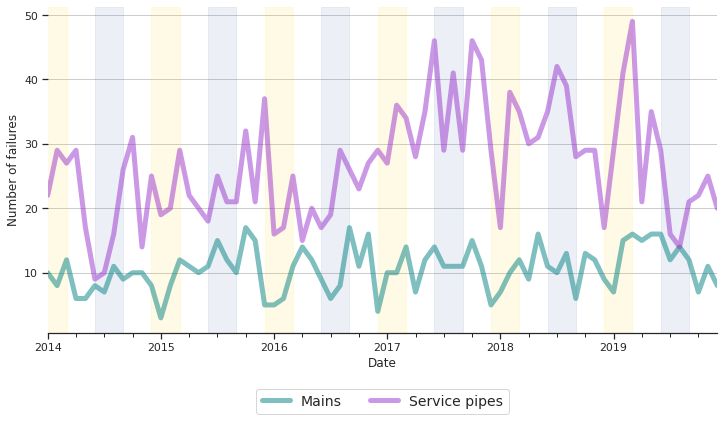

In [107]:
get3PartyGraph(mainFailures3P.copy(), serviceFailures3P.copy())

In [7]:
#get the means!! for the written up

before= mainFailures3P[mainFailures3P[ADDDTTM] < dt(2017, 1, 1, 0, 0)].copy()
after= mainFailures3P[mainFailures3P[ADDDTTM] >= dt(2017, 1, 1, 0, 0)].copy()

for df in [before,after]:
    
    df['Year']= df[ADDDTTM].dt.year
    df['Month']= df[ADDDTTM].dt.month
    df['Day']= 1

    subG = df.groupby(['Year','Month','Day']).agg({ADDDTTM: 'count'}).copy()
    
    display(subG.describe())
    
    
    

,ADDDTTM
count,36.000000
mean,9.805556
std,3.584247
min,3.000000
25%,7.750000
50%,10.000000
75%,12.000000
max,17.000000


,ADDDTTM
count,36.000000
mean,11.333333
std,3.070598
min,5.000000
25%,9.750000
50%,11.000000
75%,14.000000
max,16.000000


In [11]:
sns.set_theme(style="ticks")

In [7]:
def suburbFailureRate():
    
    res = []

    for df,lths,col in zip([mainFailures3PWAdd,servFail3PWAdd],[WMNFromAssetRecords,SPFromAssetRecords],
                       ['Water Main Line Length','Water Service Line Length']):

        lths= lths[lths[col]>0].copy()
        
        dfsub= df.groupby([SUBURB]).agg({COMPKEY: 'count'}) #number of failures

        if col == 'Water Main Line Length':
            subLeng= lths.groupby([SUBURB]).agg({col: sum})
            subLeng['Leng']=subLeng[col]/1000
        else:
            subLeng= lths.groupby([SUBURB]).agg({col: 'count'})
            subLeng.rename(columns={col:'Leng'},inplace=True)
        
        dfsub=dfsub.join(subLeng)
        colFR= 'Failures/km/year' if col=='Water Main Line Length' else 'Failures/conn/year'
        dfsub[colFR]= dfsub[COMPKEY]/dfsub['Leng']/6
        
        res.append(dfsub[[colFR]])
        
    return res
        
    
mainsSub,serviceSub=suburbFailureRate()

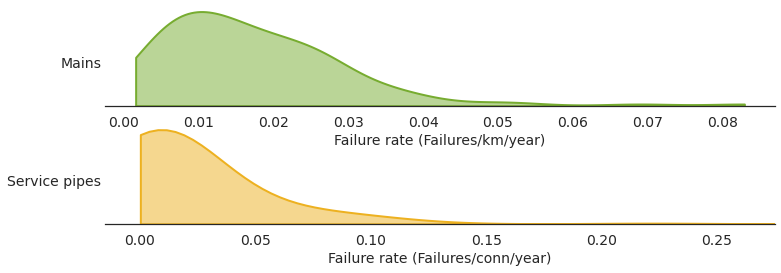

In [32]:
fig, [ax1,ax2] = plt.subplots(2,figsize=(12, 4))

        
for ax,c,l,df,xi in zip([ax1,ax2],['#77AC30','#EDB120'],["Mains","Service pipes"],[mainsSub,serviceSub],
                    ['Failures/km/year','Failures/conn/year']):
    
        ax=sns.kdeplot(data=df, x=xi,color=c,  alpha=.5, ax=ax, cut=0,fill=True, linewidth=2)
        
        ax.set(yticks=[])
        ax.spines['left'].set_visible(False)
        ax=removeTopRightFrame(ax)
        ax.set_xlabel("")
        ax.set_ylabel(l, rotation=0,ha='right',va="top")
        ax.set_xlabel("Failure rate ("+ xi + ")")
        
        if ax == ax2:
            ax.set_xlim(-0.015,0.275)
            
            
            
fig.savefig('Maps_Graph/SuburbAnalysis/'+ 'FailureRate3Party' + '.png', dpi=200,bbox_inches='tight')

 

In [35]:
print("95% quartile mains subs: ", np.quantile(mainsSub.fillna(0),0.95))
print("95% quartile serviceP subs: ", np.quantile(serviceSub.fillna(0),0.95))

95% quartile mains subs:  0.03682831461944847
95% quartile serviceP subs:  0.08959595959595959


In [33]:
q=np.quantile(mainsSub.fillna(0),0.95)

aOut= mainsSub[mainsSub['Failures/km/year']> q].copy()
aOut.sort_values(by='Failures/km/year',ascending=False)

,Failures/km/year
SUBURB,
PAREMOREMO,0.082920
BIRKENHEAD,0.068859
KELSTON,0.052078
BEACH HAVEN,0.050175
HATFIELDS BEACH,0.042331
HUIA,0.038360
WAIAKE,0.037292


In [34]:
q=np.quantile(serviceSub.fillna(0),0.95)

bOut= serviceSub[serviceSub['Failures/conn/year']> q]
bOut.sort_values(by='Failures/conn/year',ascending=False)

,Failures/conn/year
SUBURB,
RANDWICK PARK,0.750000
CLOVER PARK,0.333333
SHELLY PARK,0.333333
WAIAKE,0.222222
TOTARA VALE,0.119048
ARKLES BAY,0.100000
MATAKATIA,0.095238
SUNNYNOOK,0.092593
CASTOR BAY,0.090909


In [47]:
display(mainsSub.describe())
print(0.012677*100/0.017368)

,Failures/km/year
count,132.000000
mean,0.017368
std,0.012677
min,0.001589
25%,0.008614
50%,0.014497
75%,0.023917
max,0.082920


72.99055734684477


In [48]:
display(serviceSub.describe())
print(0.071258*100/0.027389)

,Failures/conn/year
count,171.000000
mean,0.027389
std,0.071258
min,0.000433
25%,0.003265
50%,0.007663
75%,0.022549
max,0.750000


260.1701412976012
